In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import datetime
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'ytick.minor.visible': True,})
matplotlib.rcParams.update({'xtick.minor.visible': True,})

from scipy.ndimage import gaussian_filter

import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.ndimage import gaussian_filter, zoom
from scipy.signal import find_peaks

from glob import glob
import os

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

# By Mateen Ulhaq
# See: Find nearest value in numpy array
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# pyMC

In [3]:
from pymc3 import *

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# variables: 
# wavenumber: 1D array of double. 
# tmps: 1D array of temperatures. 
# R: 2D array of intensity as a function of wavenumber and temperature. 

In [59]:
df = pd.read_csv('NaYbSe2_T_Export.csv',)
R = df.values[:, 1:].astype('float')
R = R/R.max() 
R = R[:, ::-1]

wn = df.columns[1:].values
wn = [float(line[:-3]) for line in wn]
wavenumber = wn[::-1]
tmps = df.iloc[:, 0].apply(lambda x: float(x.split('=')[-1].split('K')[0]) )

def plot_hdp(traces, color = 'blue'):
    plt.plot(tmps, traces.mean(axis = 0), lw  = 2, c = color, label = 'mean')
    plt.plot(tmps, np.percentile(traces, 50, axis = 0), lw  = 2, c = color, label = 'median', alpha = 0.5)
    plt.fill_between(tmps, np.percentile(traces, 2.5, axis = 0), np.percentile(traces, 97.5, axis = 0), 
                      facecolor=color, interpolate=True, alpha = 0.2, label = '95% CR/HDI')
    plt.legend(frameon = False)    

In [60]:
params = {"CEF1":{'data_range': (100, 140), 'peak_range': ((109, 131))}, 
          "CEF1p":{'data_range': (134, 165), 'peak_range': ((134, 165))}, 
          "A1g": {'data_range': (162, 181), 'peak_range': ((162, 181))}, 
          "CEF2":{'data_range': (180, 240), 'peak_range': ((186, 220))}, 
          "CEF3":  {'data_range': (239, 265), 'peak_range': ((239, 265))}, 
          "CEF1r2":{'data_range': (260, 295), 'peak_range': ((260, 295))}, 
          "CEF1pr2":{'data_range': (295, 320), 'peak_range': ((295, 320))},           
          "A1gr2": {'data_range': (322, 345), 'peak_range': ((322, 345))},    
          "CEF2r2":{'data_range': (344, 393), 'peak_range': ((344, 393))},  
          "CEF3r2x":{'data_range': (386, 417), 'peak_range': ((386, 417))},           
          "CEF3r2":{'data_range': (413, 450), 'peak_range': ((413, 450))},            
          "CEF1r3":{'data_range': (433, 462), 'peak_range': ((433, 462))},      
          "CEFxx":{'data_range': (460, 500), 'peak_range': ((460, 500))},          
         }

# start 

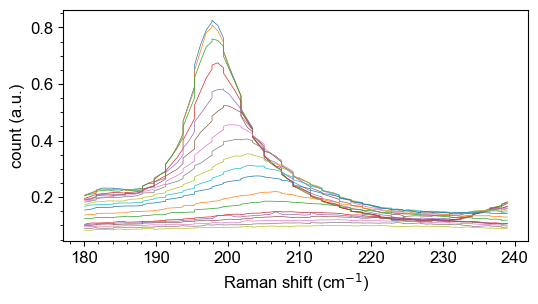

<ipython-input-61-7cf364d2211f>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(wavenumber[start:end], tmps, Y, cmap = 'jet')


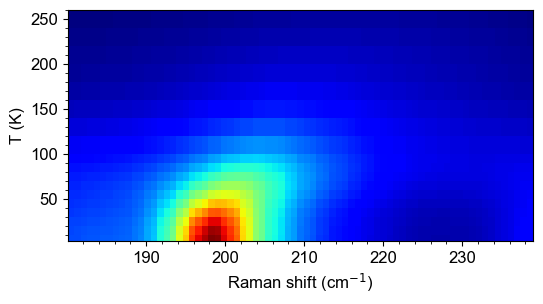

In [61]:
# pick at peak from the dictionary above 
peak_name  = 'CEF2'
data_range = params[peak_name]['data_range']
peak_range = params[peak_name]['peak_range']


plt.figure(figsize = (6, 3))
start, end = nearest(wavenumber, data_range[0]), nearest(wavenumber, data_range[1])

for k in range(len(tmps)):
    plt.plot(wavenumber[start:end], np.array(R)[k, start:end], lw = 0.5)
plt.ylabel('count (a.u.)'); plt.xlabel('Raman shift (cm$^{-1}$)')

plt.show()

Y = np.array(R)[:, start:end]
Y = gaussian_filter(Y, sigma = (1, 3))
X = np.outer(np.ones(len(tmps)), wavenumber[start:end])

plt.figure(figsize = (6, 3))
plt.pcolormesh(wavenumber[start:end], tmps, Y, cmap = 'jet')
plt.ylabel('T (K)'); plt.xlabel('Raman shift (cm$^{-1}$)')
plt.show()

In [64]:
# a column labeling which field index it is: it'll look like 0, 0, 0, 0, ..., 1, 1, 2, 2, 3, ...  
field_ID = np.outer(np.arange(len(tmps)), np.ones(end - start))

# "Field" field's actual value = field[index] give you field value
# "obs_id" flatten data's index. Dimension equals to flattened data array, or concatenated lists. 
coords = {"Field": tmps, "obs_id": np.arange(len(tmps)*Y.shape[1])}

with Model(coords = coords) as model: 
    field_idx = Data("field_idx", field_ID.ravel().astype(int), dims="obs_id")

    sigma = HalfCauchy("sigma", beta=1, testval=1.0)
    offset = Bound(Normal, lower=-1, upper = 2)("offset", 0.5, sigma = 10, dims="obs_id")
    slope = Bound(Normal, lower=-0.1, upper = 0.1)("slope", 0, sigma = 10,  dims="obs_id")

    A1_pos   = Bound(Normal, lower=peak_range[0], upper =   peak_range[1])("A1_pos", (peak_range[0] + peak_range[1])/2, sigma = 20, dims="Field")
    A1_amp   = Bound(Normal, lower=0,   upper =  1)("A1_amp", 0.8, sigma=1, dims="Field")
    A1_width = Bound(Normal, lower=0,   upper =  12)("A1_width", 2., sigma = 10, dims="Field")
    

    # making 1D array
    offset_act = offset[field_idx]
    center = A1_pos[field_idx]
    amplitude = A1_amp[field_idx]
    width = A1_width[field_idx]
    slopes = slope[field_idx]
    
    
    likelihood = Normal("Y", 
                    mu = offset_act\
                    + X.ravel()*slopes
                      + amplitude * np.exp(-(X.ravel()-center)**2/width**2/2),
                        sigma=sigma, observed= Y.ravel())

    trace = sample(3000, cores=4)  

<ipython-input-64-1135119e2d4b>:34: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = sample(3000, cores=4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A1_width, A1_amp, A1_pos, slope, offset, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 1275 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


C:\Users\2py\Anaconda3\envs\bayes2\lib\site-packages\arviz\data\io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
C:\Users\2py\Anaconda3\envs\bayes2\lib\site-packages\arviz\plots\plot_utils.py:490: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (4010) in plot_posterior, generating only 40 plots
  warnings.warn(
<ipython-input-67-923e214b1af9>:4: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


<Figure size 600x300 with 0 Axes>

<Figure size 700x700 with 0 Axes>

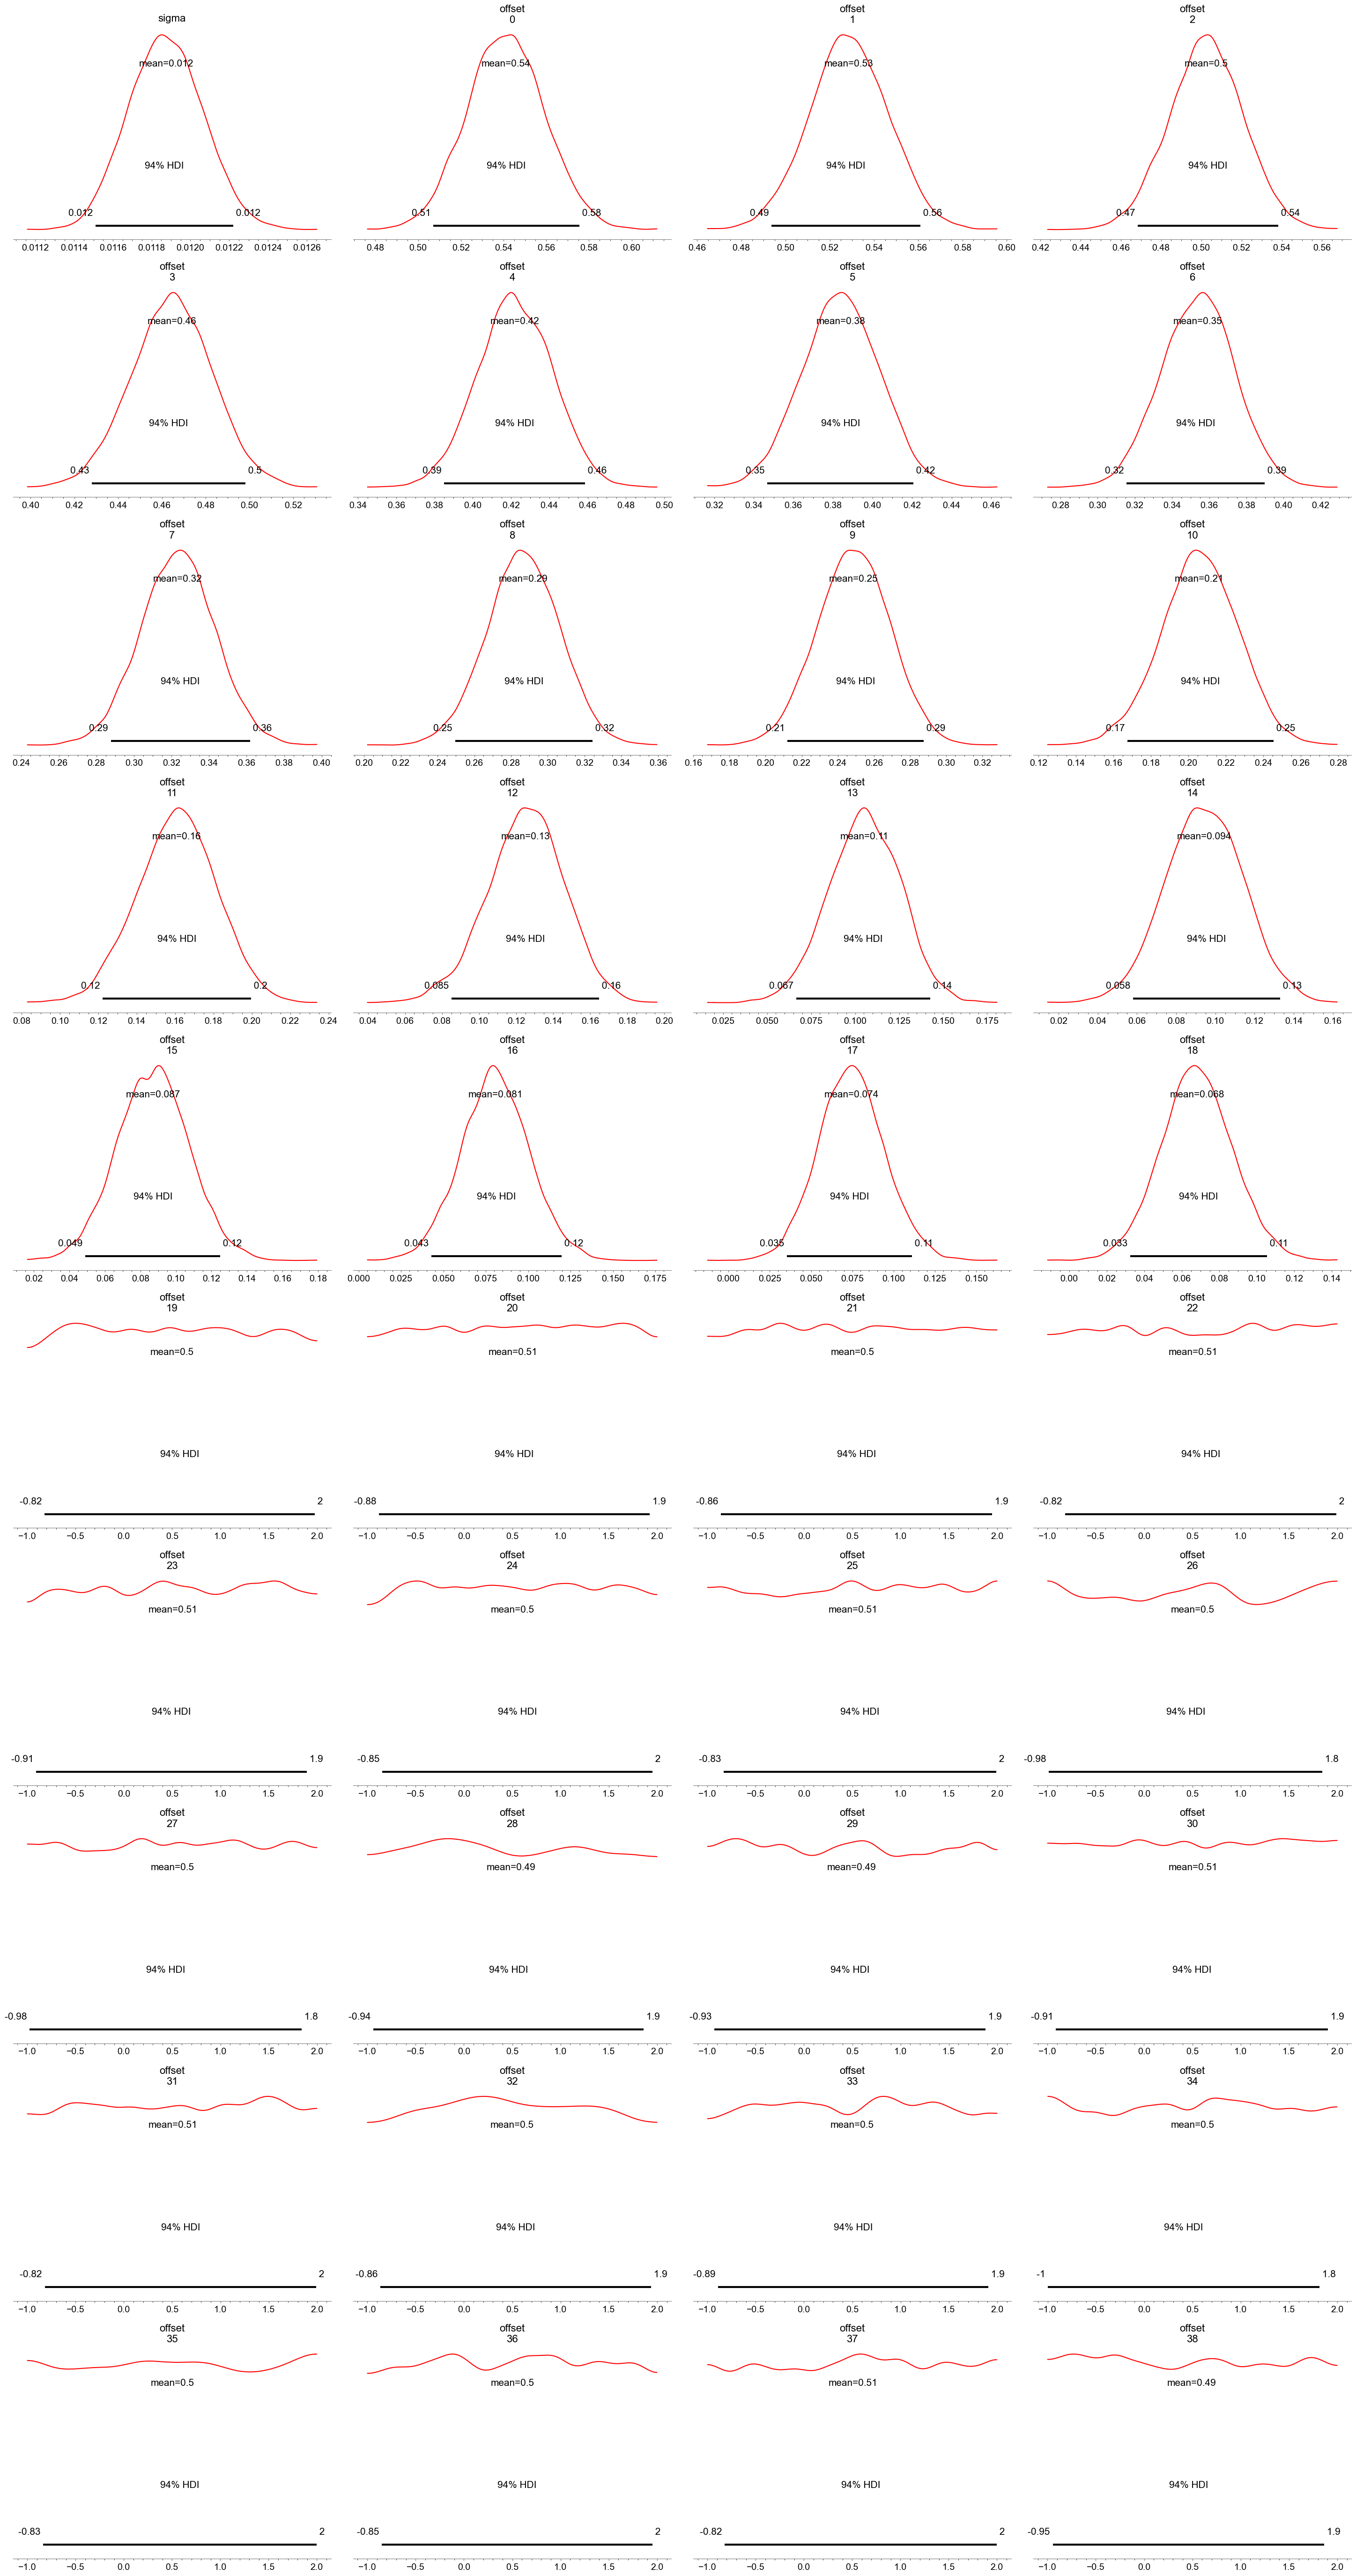

<ipython-input-67-923e214b1af9>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(wavenumber[start:end],


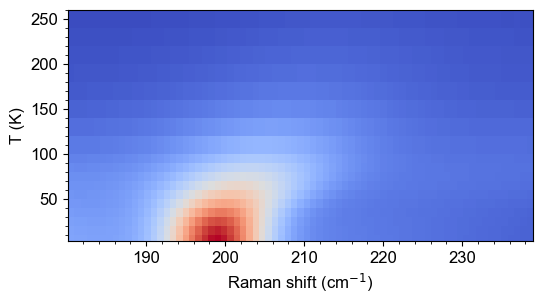

In [67]:
plt.figure(figsize=(7, 7))
#traceplot(trace)
plot_posterior(trace, c = 'red')
plt.tight_layout();
#plt.savefig("i={}".format(i_n) + ".png", dpi = 150)
plt.show()

with model:
    ppc = sample_posterior_predictive(
        trace, var_names=["sigma", "offset", "slope",
                          "Y", 
                          'A1_pos', 'A1_amp', 'A1_width',
                          ], random_seed=42
    )
    
    
plt.figure(figsize = (6, 3))
plt.pcolormesh(wavenumber[start:end],  
               tmps, 
               ppc['Y'].reshape(12000, len(tmps), Y.shape[1]).mean(axis = 0), cmap = 'coolwarm')
plt.ylabel('T (K)'); plt.xlabel('Raman shift (cm$^{-1}$)', )
plt.show()

import pickle # python3
with open("Na_R1_T_" + peak_name + ".pkl", 'wb') as buff:
    pickle.dump({'model': model, 'trace': trace}, buff)

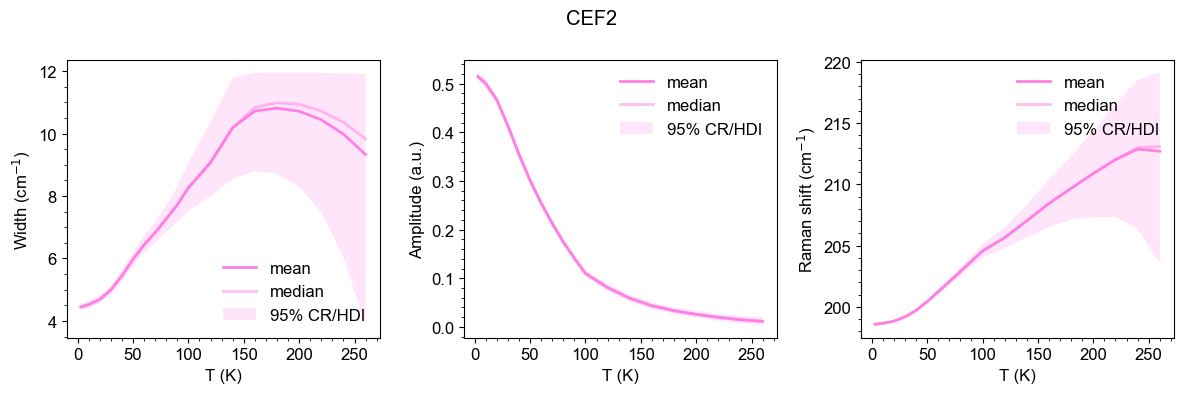

In [68]:
plt.figure(figsize = (12, 4))
plt.suptitle(peak_name)
plt.subplot(131)
plot_hdp(trace['A1_width'], '#ff80e5ff')
plt.legend(frameon = False)
plt.xlabel('T (K)')
plt.ylabel('Width (cm$^{-1}$)', )

plt.subplot(132)
plot_hdp(trace['A1_amp'], '#ff80e5ff')
plt.xlabel('T (K)')
plt.ylabel('Amplitude (a.u.)', )

plt.subplot(133)
plot_hdp(trace['A1_pos'], '#ff80e5ff')
plt.legend(frameon = False)
plt.xlabel('T (K)')
plt.ylabel('Raman shift (cm$^{-1}$)', )
plt.tight_layout()
plt.show()